### Checking if data is loaded

In [1]:
!ls /kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


### Importing the modules and Supressing the warnings

In [2]:
import os
import pydicom
from glob import glob
from collections import defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import random
random.seed(2708)
import json
import shutil

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

### Defining and loading the paths of the files and the labels

In [3]:
base = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection"
data_dir = os.path.join(base, "stage_2_train")
label_csv = os.path.join(base, "stage_2_train.csv")
labels_df = pd.read_csv(label_csv)
dicom_paths = glob(os.path.join(data_dir, "*.dcm"))

### Creating the volume dictionaries (Dont run if the .pkl files are available)

In [ ]:
# Initializing the dictionaries
volumes_counts = defaultdict(int)
volumes_slices = defaultdict(list)

# Creating a function to read DICOM metadata and return (series_id, dicom_id) tuple
def process_dicom(path):
    # Reading each data file
    dcm = pydicom.dcmread(path, stop_before_pixels=True)
    # Extracting the series instance ID which allows us to group the 2D data to 3D volumes
    series_id = dcm.SeriesInstanceUID
    # Extracting the file ID for easy lookup while merging the 2D data to 3D volumes
    dicom_id = os.path.basename(path).replace(".dcm", "")
    # Returning the extracted tuple
    return series_id, dicom_id

print(f"Processing {len(dicom_paths)} DICOM files in parallel.")

# Using ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=8) as executor:
    # Scheduling all files and returns results in order using executor.map
    # Iterating over the tasks and visualizing the progress using tqdm
    for series_id, dicom_id in tqdm(
        executor.map(process_dicom, dicom_paths),
        total=len(dicom_paths),
        desc="Building the dictionaries"
    ):
        # Updating both the dictionaries appropriately
        volume_counts[series_id] += 1
        volume_slices[series_id].append(dicom_id)

print(f"\nFound {len(volume_counts)} unique SeriesInstanceUIDs.")

### Storing the volume dictionaries (Dont run if the .pkl files are available)

In [ ]:
# Saving the volume_counts dictionary
with open("volume_counts.pkl", "wb") as f:
    pickle.dump(volume_counts, f)
# Saving the volume_slices dictionary
with open("volume_slices.pkl", "wb") as f:
    pickle.dump(volume_slices, f)
print("Dictionaries saved successfully!")

### Creating the label dictionary (Dont run if the .pkl files are available)

In [ ]:
# Defining the subtypes
subtypes = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

# Preprocessing the labels into a dictionary of sets for fast lookup
labels_dict = defaultdict(set)
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Processing all volume labels"):
    # Extracting the ID and label value for that row
    dicom_id, label = row['ID'], row['Label']
    # If the label is positive
    if label == 1:
        # Extracting the dicom ID
        dicom_base = dicom_id.rsplit('_', 1)[0]
        # Extracting the subtype
        subtype = dicom_id.rsplit('_', 1)[-1]
        # Adding the subtype to the set of that particular dicom ID
        labels_dict[dicom_base].add(subtype)

# Creating a function to get 6 tuple binary labels
def get_binary_labels(dicom_id):
    present = labels_dict.get(dicom_id, set())
    return tuple(1 if st in present else 0 for st in subtypes)

# Building the dictionary for the volumes
volume_binary_labels = {}
for volume_id, dicom_ids in tqdm(volume_slices.items(), desc="Converting to binary labels"):
    for dicom_id in dicom_ids:
        volume_binary_labels[dicom_id] = get_binary_labels(dicom_id)

### Storing the label dictionaries (Dont run if the .pkl files are available)

In [ ]:
# Saving the volume_binary_labels dictionary
with open("volume_binary_labels.pkl", "wb") as f:
    pickle.dump(volume_binary_labels, f)
print("Dictionary saved successfully!")

### Loading all the dictionaries

In [4]:
# Loading the volume_counts dictionary
with open("/kaggle/input/loaded-data/volume_counts.pkl", "rb") as f:
    volume_counts = pickle.load(f)
# Loading the volume_slices dictionary
with open("/kaggle/input/loaded-data/volume_slices.pkl", "rb") as f:
    volume_slices = pickle.load(f)
# Loading the volume_binary_labels dictionary
with open("/kaggle/input/loaded-data/volume_binary_labels.pkl", "rb") as f:
    volume_binary_labels = pickle.load(f)
print("Dictionaries loaded successfully!")
print(f"Number of volumes: {len(volume_counts)}")
print(f"Number of slices: {sum(volume_counts.values())}")
print(f"Number of labels: {len(volume_binary_labels)}")

Dictionaries loaded successfully!
Number of volumes: 21744
Number of slices: 752803
Number of labels: 752803


### Visualizing the histogram of the results

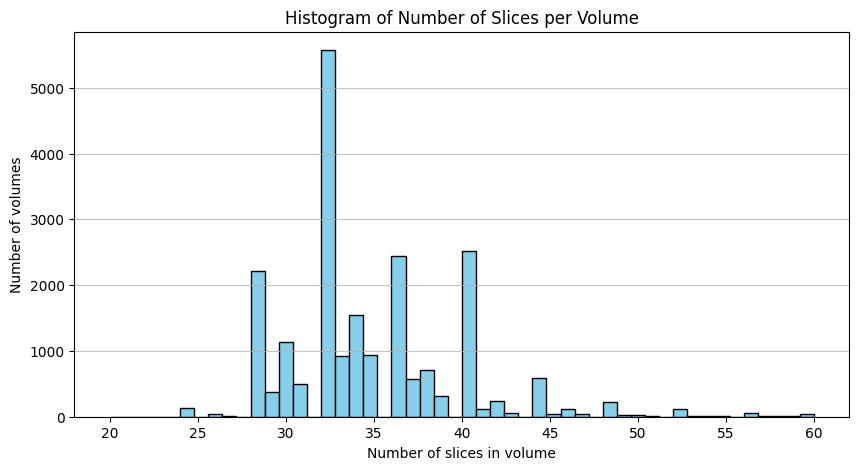

In [5]:
# Extracting the counts (number of slices per volumes)
counts = list(volume_counts.values())

# Plotting the histogram
plt.figure(figsize=(10, 5))
plt.hist(counts, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Number of Slices per Volume")
plt.xlabel("Number of slices in volume")
plt.ylabel("Number of volumes")
plt.grid(axis='y', alpha=0.75)
plt.show()

### Verifying how many slices are present in most of the volumes

In [6]:
# Count how many volumes have each slice count
slice_count_freq = Counter(volume_counts.values())

# Setting the threshold
threshold = 2000

# Filter slice counts that occur in more than threshold number of volumes
threshold_counts = {count: freq for count, freq in slice_count_freq.items() if freq > threshold}

print(f"Slice counts occurring in more than {threshold} volumes:")
for count, freq in sorted(threshold_counts.items()):
    print(f"{count} slices : {freq} volumes")

Slice counts occurring in more than 2000 volumes:
28 slices : 2218 volumes
32 slices : 5574 volumes
36 slices : 2444 volumes
40 slices : 2523 volumes


### Viewing the slices and labels for a particular randomly chosen volume

Randomly selected volume: ID_85144130cd
Number of slices in this volume: 28
Aggregated label: (0, 0, 0, 0, 1, 1)


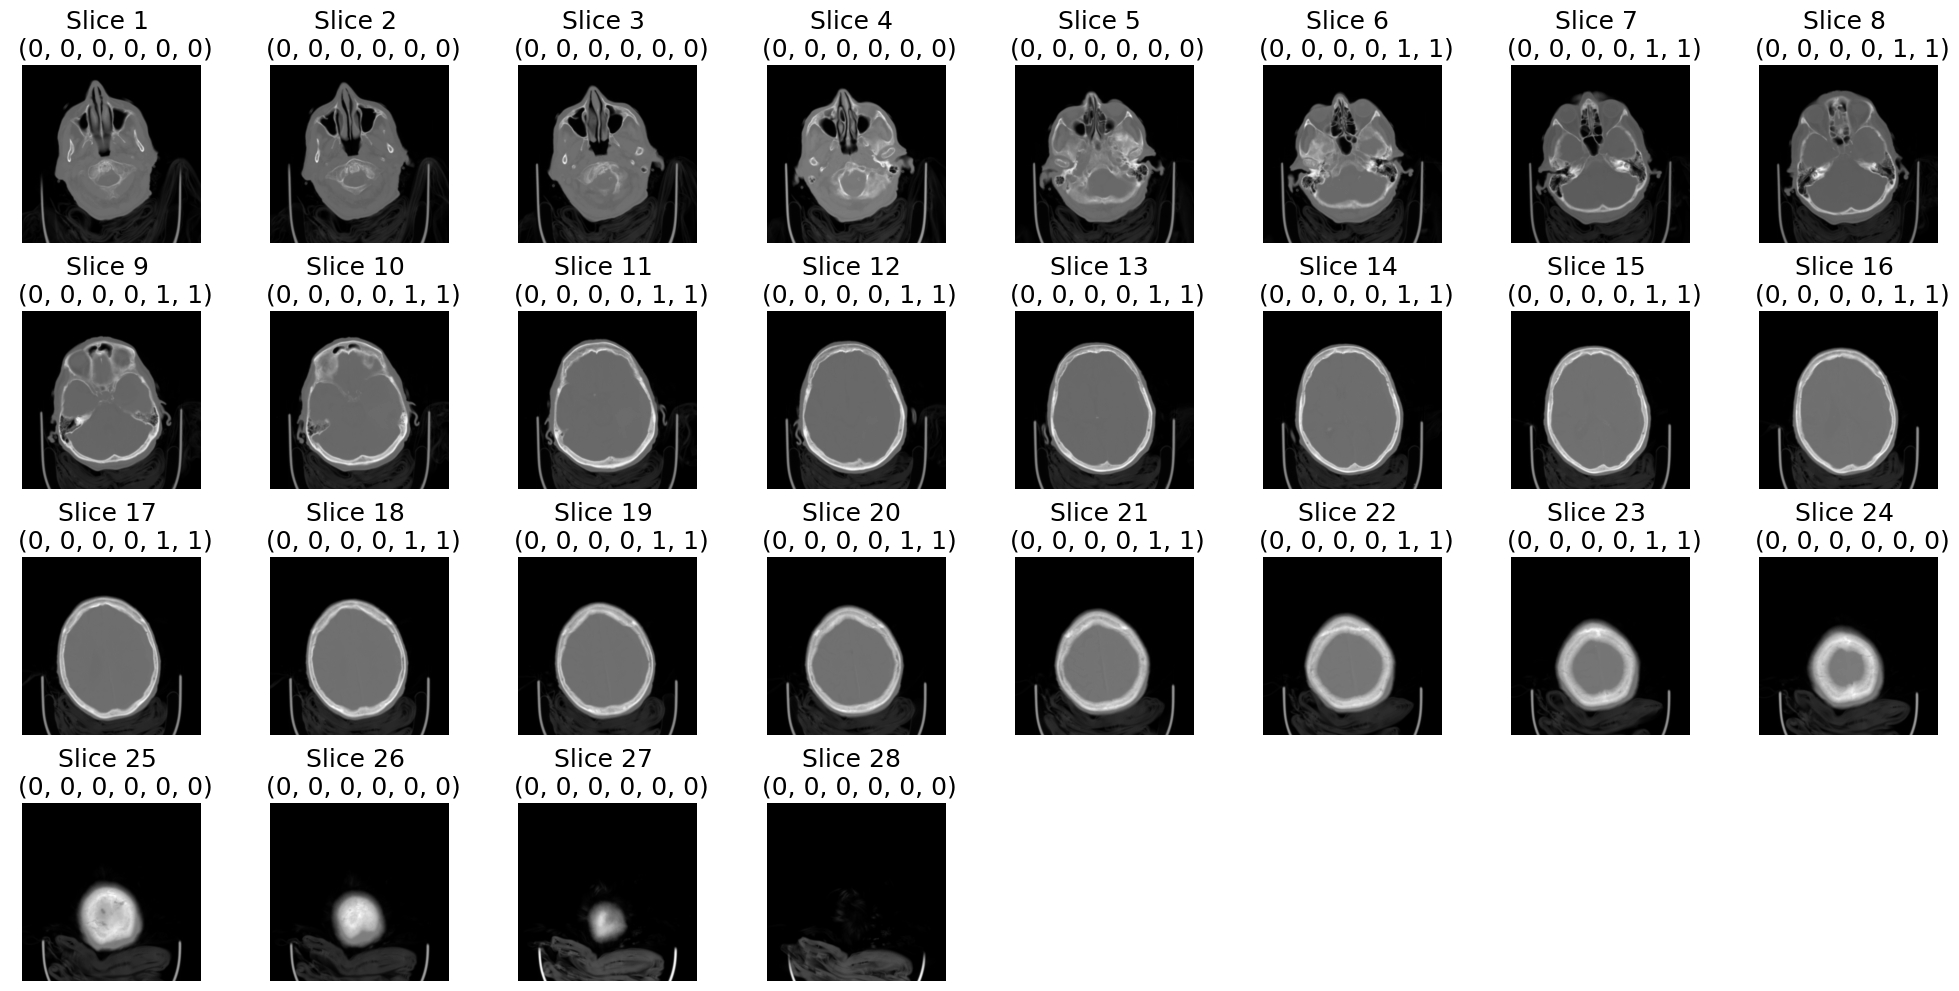

In [7]:
# Pick a random volume ID from volume_slices
target_volume_id = random.choice(list(volume_slices.keys()))

print(f"Randomly selected volume: {target_volume_id}")
print(f"Number of slices in this volume: {len(volume_slices[target_volume_id])}")

# Get DICOM files for the target volume
dicom_ids = volume_slices[target_volume_id]
dicom_files = [os.path.join(data_dir, f"{dicom_id}.dcm") for dicom_id in dicom_ids]

# Creating a function to get the aggregated label
def aggregate_labels_max(dicom_ids):
    # Taking the max value per suptype as if a hemorrage exists in one slice, it exists in the entire volume too
    return tuple(np.max([volume_binary_labels[id_] for id_ in dicom_ids],axis=0))

# Creating a function to get the z-position from the ImagePositionPatient parameter from the metadata
def get_z_position(fpath):
    # Reading each data file
    dcm = pydicom.dcmread(fpath, stop_before_pixels=True)
    # Extrcating the image position patient data which provides the z-axis (depth / sequencial) position
    pos = dcm.ImagePositionPatient
    if pos is not None:
        # Returning the depth coordinate
        return float(pos[2])
    else:
        # If the depth coordinate is not present then appending it to the end
        return float('inf')

# Sorting the files / slices by z-position
dicom_files_sorted = sorted(dicom_files, key=get_z_position)

print(f"Aggregated label: {aggregate_labels_max(dicom_ids)}")

# Plotting all slices in a grid
n_slices = len(dicom_files_sorted)
n_cols = 8
n_rows = (n_slices + n_cols - 1) // n_cols
plt.figure(figsize=(20, n_rows*2.5))
for i, fpath in enumerate(dicom_files_sorted):
    dcm = pydicom.dcmread(fpath)
    id_ = os.path.basename(fpath).replace(".dcm", "")
    img = dcm.pixel_array
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Slice {i+1} \n {volume_binary_labels[id_]}", fontsize=18)
plt.tight_layout()
plt.show()

### Counting the frequency of the triplet labels

In [8]:
# Initializing the dictionary to store the triplets in an aggregated (grouped) manner with respect to their labels
volume_triplets = defaultdict(list)

for series_id, series in tqdm(volume_slices.items(), desc="Extracting triplets"):
    # Skipping if the volume has less than 3 slices
    if len(series) < 3:
        continue
    i = 0
    # Scanning all the slices within the volume
    while i < len(series) - 2:
        # Checking if three consecutive slices share identical labels
        l1 = volume_binary_labels[series[i]][:-1]
        l2 = volume_binary_labels[series[i + 1]][:-1]
        l3 = volume_binary_labels[series[i + 2]][:-1]
        # If they do share the same labels then we consider them
        if l1 == l2 == l3:
            volume_triplets[tuple(l1)].append([series[i], series[i + 1], series[i + 2]])
            # Jumping ahead by 3 to avoid overlap
            i += 3
        else:
            # If they do not share the same labels then we keep sweeping
            i += 1

print(f"Found {sum(len(v) for v in volume_triplets.values())} volumes with valid triplets.")
print(f"Unique label configurations: {len(volume_triplets)}")

Extracting triplets: 100%|██████████| 21744/21744 [00:01<00:00, 21165.76it/s]

Found 192041 volumes with valid triplets.
Unique label configurations: 27


In [9]:
print(volume_triplets.keys())
print([len(v) for v in volume_triplets.values()])

dict_keys([(0, 0, 0, 0, 0), (0, 1, 0, 1, 1), (0, 0, 0, 1, 0), (0, 0, 0, 0, 1), (0, 1, 0, 0, 0), (0, 1, 1, 0, 0), (0, 0, 1, 0, 0), (0, 0, 0, 1, 1), (0, 1, 0, 1, 0), (1, 1, 0, 1, 0), (0, 1, 1, 0, 1), (0, 1, 1, 1, 0), (1, 0, 0, 0, 0), (0, 1, 0, 0, 1), (0, 1, 1, 1, 1), (0, 0, 1, 1, 1), (0, 0, 1, 1, 0), (1, 0, 0, 0, 1), (1, 1, 0, 1, 1), (0, 0, 1, 0, 1), (1, 0, 0, 1, 1), (1, 1, 0, 0, 1), (1, 0, 0, 1, 0), (1, 1, 0, 0, 0), (1, 0, 1, 1, 1), (1, 1, 1, 0, 0), (1, 1, 1, 0, 1)])
[186430, 58, 924, 3193, 409, 110, 305, 187, 72, 1, 9, 37, 85, 55, 19, 17, 87, 14, 3, 8, 1, 2, 4, 8, 1, 1, 1]


### Sampling triplets in a stratified manner

In [10]:
# Defining the desired target sample sizes per category
targets = {
    (1,0,0,0,0): 85,  # epidural
    (0,1,0,0,0): 300, # intraparenchymal
    (0,0,1,0,0): 300, # intraventricular
    (0,0,0,1,0): 300, # subarachnoid
    (0,0,0,0,1): 300, # subdural
    'multiple': 500,  # multiple hemorrhage types
    (0,0,0,0,0): 500  # no hemorrhage
}

# Initializing the subset dictionary
balanced_triplets = defaultdict(list)

# Iterating over the target configurations
for label, target_count in tqdm(targets.items(), desc="Selecting balanced triplets"):
    # Selecting candidate triplets based on label type
    if label == 'multiple':
        # Labels having more than one positive subtype
        candidates = [t for k, v in volume_triplets.items() if sum(k) > 1 for t in v]
        key = 'multiple'
    else:
        # Directly looking up for single-label or none cases
        candidates = volume_triplets.get(label, [])
        key = label
    # Randomly choosing the triplets
    sampled = random.sample(candidates, target_count)
    # Storing the selected triplets under the correct key
    balanced_triplets[key].extend(sampled)

# Print a quick summary
print("\n Balanced subset created successfully!")
for k, v in balanced_triplets.items():
    label_name = k if k == 'multiple' else str(k)
    print(f"Label {label_name}: {len(v)} triplets")

total_triplets = sum(len(v) for v in balanced_triplets.values())
print(f"Total selected triplets: {total_triplets}")
print(f"Total selected slices: {total_triplets*3}")

Selecting balanced triplets: 100%|██████████| 7/7 [00:00<00:00, 4328.49it/s]


 Balanced subset created successfully!
Label (1, 0, 0, 0, 0): 85 triplets
Label (0, 1, 0, 0, 0): 300 triplets
Label (0, 0, 1, 0, 0): 300 triplets
Label (0, 0, 0, 1, 0): 300 triplets
Label (0, 0, 0, 0, 1): 300 triplets
Label multiple: 500 triplets
Label (0, 0, 0, 0, 0): 500 triplets
Total selected triplets: 2285
Total selected slices: 6855


### Saving the sampled (subset) data

In [11]:
# Defining the root output directory
output_root = "balanced_triplets"
os.makedirs(output_root, exist_ok=True)

# Mapping the triplet to its label
triplet_label = {}

# Initializing the index for the triplets
idx = 0

# Iterating through each label category
for label, triplets in tqdm(balanced_triplets.items(), desc="Saving triplets"):
    # Making a label-specific subfolder, if it does not exist
    label_dir = os.path.join(output_root, str(label))
    os.makedirs(label_dir, exist_ok=True)
    # Iterating through all triplets in this label
    for triplet in triplets:
        triplet_id = f"triplet_{idx:03d}"
        # Making a triplet-specific sub-subfolder, if it does not exist
        triplet_dir = os.path.join(label_dir, triplet_id)
        os.makedirs(triplet_dir, exist_ok=True)
        # Copying the DICOM files for this triplet
        for slice_id in triplet:
            src = os.path.join(data_dir, f"{slice_id}.dcm")
            dst = os.path.join(triplet_dir, f"{slice_id}.dcm")
            shutil.copy2(src, dst)
        # Storing the label for the triplet
        triplet_label[triplet_id] = label
        # Incrementing the triplet index
        idx+=1

# Saving the mapping as JSON
json_path = os.path.join(output_root, "labels.json")
with open(json_path, "w") as f:
    json.dump(triplet_label, f, indent=2)

# Zipping everything allowing us to export it
shutil.make_archive("triplets", 'zip', output_root)

Saving triplets: 100%|██████████| 7/7 [02:43<00:00, 23.36s/it]


'/kaggle/working/triplets.zip'